In [46]:
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings('ignore')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
SEED = 42

In [48]:
list_businesses = [line.strip() for line in open("list_of_businesses.txt", 'r')]
list_hs_codes = [line.strip() for line in open("list_hs_codes.txt", 'r')]
list_strengthes = [line.strip() for line in open("list_strengthes.txt", 'r')]

In [49]:
def prepare_data(path, status, threshold=None):
    """
    path, str to dataset, e.g 'model_passed_review.csv'
    status, could be 'passed' or 'failed'
    threshold - limit the number of rows in dataset
    e.g. prepare_data('model_passed_review.csv', 'passed')
    """
    df = pd.read_csv(path, header = None)
    
    df = df.drop([4, 5], axis=1)
    df = df.rename(columns=
                       {0 : "Business", 
                        1 : "Part_number",
                        2 : "Part_description",
                        3 : "HS_code",
                        6 : "Audit_trail",
                        7 : "Strength"})
    df = df.drop_duplicates(subset=['Audit_trail', 'HS_code']).reset_index(drop=True)
    #threshold
    if threshold != None:
        df = df.sample(random_state=SEED, frac=1).reset_index(drop=True)
        df = df[:threshold]

    df = df.fillna('missed_data')
    df['HS_code'] = df['HS_code'].astype('str')
    df['Strength'] = df['Strength'].astype('str')
    #converting the missing strengthes
    df['Business'] = df['Business'].apply(lambda x: x if x in list_businesses else 'unknown')
    df['HS_code'] = df['HS_code'].apply(lambda x: x if x in list_hs_codes else 'unknown')
    df['Strength'] = df['Strength'].apply(lambda x: x if x in list_strengthes else 'unknown')
    #adding the label
    if status == "passed":
        df['Failed'] = 0
    else:
        df['Failed'] = 1
    df_text = df['Part_number'] + " " + df['Part_description'] + " " + df['Audit_trail']
    df_features = df[['Business', 'HS_code', 'Strength']]
    y = df['Failed']

    return df_text, df_features, y

In [50]:
passed_text, passed_features, y_passed = prepare_data('model_passed_review.csv', 'passed')
failed_text, failed_features, y_failed = prepare_data('model_failed_review.csv', 'failed')

In [51]:
df_train_text = pd.concat([passed_text, failed_text], ignore_index=True)
df_train_features = pd.concat([passed_features, failed_features], ignore_index=True)
y = pd.concat([y_passed, y_failed], ignore_index=True)

In [52]:
enc = OneHotEncoder(categories=(list_businesses, list_hs_codes, list_strengthes))

In [53]:
df_train_features_sparse = enc.fit_transform(df_train_features)
df_train_features_sparse

<161184x1365 sparse matrix of type '<class 'numpy.float64'>'
	with 483552 stored elements in Compressed Sparse Row format>

In [54]:
df_train_features_sparse.shape[1] == len(list_businesses) + len(list_hs_codes) + len(list_strengthes)

True

In [55]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

cachedStopWords = stopwords.words("english")

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text

stemmer = SnowballStemmer('english')
#stemmer = PorterStemmer()
#lemmatizer = WordNetLemmatizer()

In [56]:
#The function takes as input dataset and columns to process
def clean_data(df):
    df = df.apply(lambda x : remove_URL(x))
    df = df.apply(lambda x : remove_punct(x))
    df = df.apply(lambda x : remove_stopwords(x))
    df = df.apply(lambda x : stemmer.stem(x))
    # df = df.apply(lambda x : lemmatizer.lemmatize(x))

    return df

In [57]:
df_cleaned_train_text = clean_data(df_train_text)
print('text reducing is ', len(" ".join(df_cleaned_train_text))/len(" ".join(df_train_text)))

text reducing is  0.7975512900723838


In [58]:
df_cleaned_train_text

0         2c6800g01 nickel eye lift per dwb drawing nick...
1         018713194 loctite 243 thread sealant adhesive ...
2         021812124 cup point set screw per technical re...
3         021812166 cup setsc per technical response att...
4         02250125372 filter house filter per provided e...
                                ...                        
161179    xa4430n015 electromagnetic disk brakes electri...
161180    xc130050149 container per attached email photo...
161181    xh1800814 lam grinder drum per engineer respon...
161182    xlgoc3920 borescope probe video per provided d...
161183    z5590c lifting device wind turbine steel per a...
Length: 161184, dtype: object

In [59]:
MAX_DF = 0.8
MIN_COUNT = 5
NGRAMS = (1, 1)
MAX_FEATURES = 20000

In [60]:
tfidf_vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_COUNT, ngram_range=NGRAMS, max_features=MAX_FEATURES)
df_cleaned_train_text_sparse = tfidf_vectorizer.fit_transform(df_cleaned_train_text)

In [61]:
df_total = hstack([df_train_features_sparse, df_cleaned_train_text_sparse])
df_total

<161184x21365 sparse matrix of type '<class 'numpy.float64'>'
	with 4210107 stored elements in COOrdinate format>

In [62]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df_total, y, 
                                                          test_size=0.3, 
                                                          random_state=SEED)

In [63]:
clf = LogisticRegression(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % accuracy_score(y_train, clf.predict(X_train)))
print('F1 score (holdout) %.3f' % accuracy_score(y_holdout, clf.predict(X_holdout)))

F1 score (train) 1.000
F1 score (holdout) 1.000


In [64]:
clf.predict(X_train)

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [65]:
clf2 = RidgeClassifier(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf2.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf2.predict(X_holdout)))

F1 score (train) 1.000
F1 score (holdout) 1.000


In [66]:
clf3 = MultinomialNB().fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf3.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf3.predict(X_holdout)))

F1 score (train) 1.000
F1 score (holdout) 1.000


In [67]:
clf4 = svm.LinearSVC(random_state=SEED).fit(X_train, y_train)
print('F1 score (train) %.3f' % f1_score(y_train, clf4.predict(X_train)))
print('F1 score (holdout) %.3f' % f1_score(y_holdout, clf4.predict(X_holdout)))

F1 score (train) 1.000
F1 score (holdout) 1.000


In [68]:
test_passed_text, test_passed_features, y_passed_test = prepare_data('test_passed_review.csv', 'passed')
test_failed_text, test_failed_features, y_failed_test = prepare_data('test_failed_review.csv', 'failed')

In [69]:
df_test_text = pd.concat([test_passed_text, test_failed_text], ignore_index=True)
df_test_features = pd.concat([test_passed_features, test_failed_features], ignore_index=True)
y_test = pd.concat([y_passed_test, y_failed_test], ignore_index=True)

# # only passed
# df_test_text = test_passed_text
# df_test_features = test_passed_features
# y_test = y_passed_test

# # only failed
# df_test_text = test_failed_text
# df_test_features = test_failed_features
# y_test = y_failed_test

In [70]:
df_test_features_sparse = enc.transform(df_test_features)
df_test_features_sparse

<53803x1365 sparse matrix of type '<class 'numpy.float64'>'
	with 161409 stored elements in Compressed Sparse Row format>

In [71]:
df_test_features_sparse.shape[1] == len(list_businesses) + len(list_hs_codes) + len(list_strengthes)

True

In [72]:
df_cleaned_test_text = clean_data(df_test_text)
print('text reducing is ', len(" ".join(df_cleaned_test_text))/len(" ".join(df_test_text)))

text reducing is  0.791814864696335


In [74]:
df_cleaned_test_text = tfidf_vectorizer.transform(df_cleaned_test_text)
df_cleaned_test_text

<53803x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 1229711 stored elements in Compressed Sparse Row format>

In [75]:
X_test = hstack([df_test_features_sparse, df_cleaned_test_text])

In [76]:
print('Logistic regression F1 score (test) %.3f' % f1_score(y_test, clf.predict(X_test)))
print('Ridge Clasifier F1 score (test) %.3f' % f1_score(y_test, clf2.predict(X_test)))
print('Naive Bayes F1 score (test) %.3f' % f1_score(y_test, clf3.predict(X_test)))
print('Linear SVM F1 score (test) %.3f' % f1_score(y_test, clf4.predict(X_test)))

Logistic regression F1 score (test) 0.443
Ridge Clasifier F1 score (test) 0.443
Naive Bayes F1 score (test) 0.450
Linear SVM F1 score (test) 0.443


In [77]:
# # only passed
# print('Logistic regression accuracy score (test) %.3f' % accuracy_score(y_test, clf.predict(X_test)))
# print('Ridge Clasifier accuracy score (test) %.3f' % accuracy_score(y_test, clf2.predict(X_test)))
# print('Naive Bayes accuracy score (test) %.3f' % accuracy_score(y_test, clf3.predict(X_test)))
# print('Linear SVM accuracy score (test) %.3f' % accuracy_score(y_test, clf4.predict(X_test)))

In [78]:
# # only failed
# print('Logistic regression accuracy score (test) %.3f' % accuracy_score(y_test, clf.predict(X_test)))
# print('Ridge Clasifier accuracy score (test) %.3f' % accuracy_score(y_test, clf2.predict(X_test)))
# print('Naive Bayes accuracy score (test) %.3f' % accuracy_score(y_test, clf3.predict(X_test)))
# print('Linear SVM accuracy score (test) %.3f' % accuracy_score(y_test, clf4.predict(X_test)))

In [79]:
preds = pd.DataFrame(clf.predict_proba(X_test), columns = ['Prob_of_0', 'Prob_of_1'])

In [80]:
preds['AT'] = df_test_text
preds[['Business', 'HS_code', 'Strength']] = df_test_features
preds['True'] = y_test

In [81]:
preds[(preds['Prob_of_0'] > 0.4) & (preds['Prob_of_0'] < 0.5) & (preds['True'] == 0)]

,Prob_of_0,Prob_of_1,AT,Business,HS_code,Strength,True


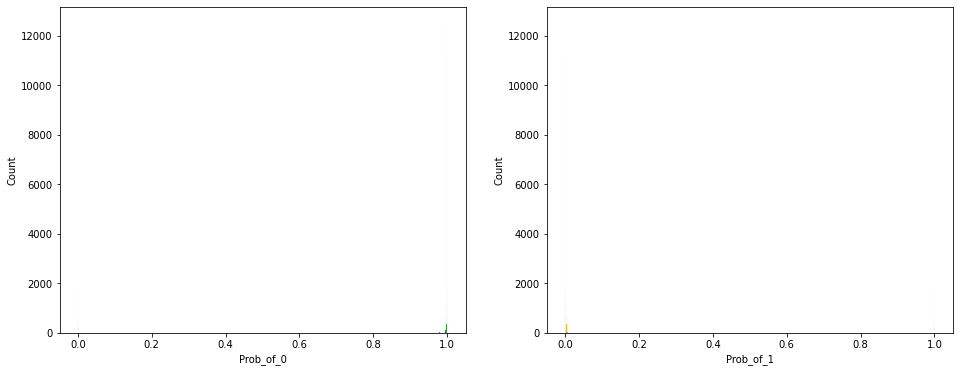

In [488]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(preds['Prob_of_0'], color='green', ax=axs[0])
sns.histplot(preds['Prob_of_1'], color='orange', ax=axs[1]);